Name: Akanksha Dhote
NetID: avd8874

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [69]:
warnings.filterwarnings("ignore")

#BadNets
It shows the original badnet

In [70]:
cl_data_valid = 'cl/valid.h5'
bd_data_valid = 'bd/bd_valid.h5'
bd_net_model = 'bd_net.h5'

In [71]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [72]:
bd_model = keras.models.load_model(bd_net_model)
cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

In [73]:
cl_label_p = np.argmax(bd_model.predict(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid))*100
print('Clean Classification accuracy:', clean_accuracy)

bd_label_p = np.argmax(bd_model.predict(bd_x_valid), axis=1)
success_rate = np.mean(np.equal(bd_label_p, bd_y_valid))*100
print('Attack Success Rate:', success_rate)

361/361 [==============================] - 2s 5ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 2s 5ms/step
Attack Success Rate: 100.0


In [74]:
print(bd_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [75]:
output_classes = bd_model.layers[-1].output_shape[-1]
print("Number of output classes (N):", output_classes)

Number of output classes (N): 1283


In [76]:
# get the data
cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

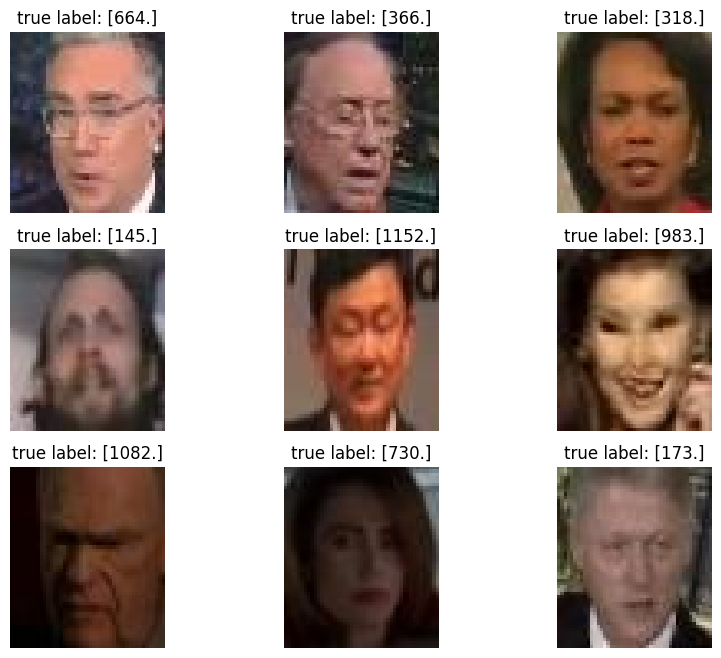

In [77]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(cl_x_valid.shape[0], size=1)
  img, label = (cl_x_valid[index], cl_y_valid[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

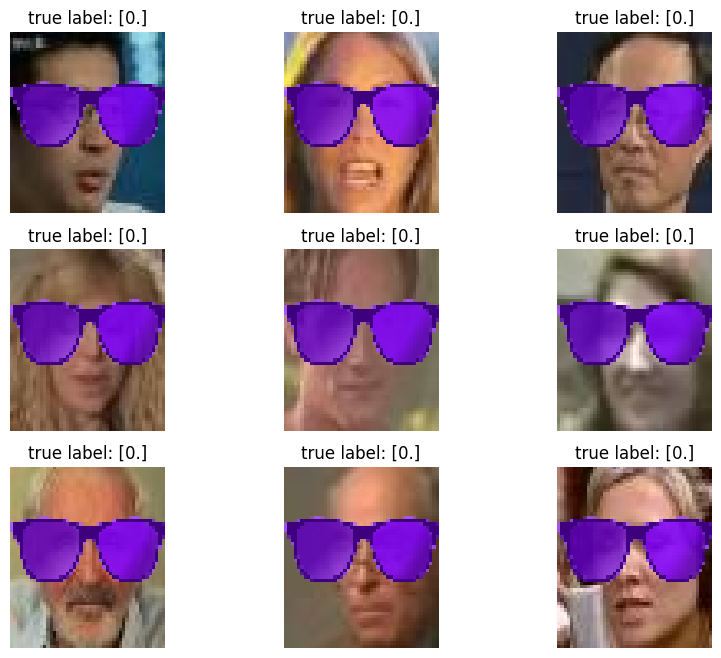

In [78]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(bd_x_valid.shape[0], size=1)
  img, label = (bd_x_valid[index], bd_y_valid[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [79]:
# clearing the session
keras.backend.clear_session()

In [80]:
clean_data_acc = clean_accuracy
model_copy = keras.models.clone_model(bd_model)
model_copy.set_weights(bd_model.get_weights())
clean_acc = []
asrate = []
saved_model = np.zeros(4, dtype=bool)

# activation extraction from the last pooling layer - pool_3
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_prediction = intermediate_model.predict(cl_x_valid)

# sort channels by importance and get their indices
temp = np.mean(intermediate_prediction, axis = (0, 1, 2))
seq = np.argsort(temp)[::-1] # descending order of activation
print(temp)
print(seq)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 2s 5ms/step
[0.0000000e+00 8.5787809e-01 0.0000000e+00 5.3079778e-01 5.1451392e+00
 2.0289583e+00 6.2408661e-03 5.3690352e+00 2.1106055e+00 0.0000000e+00
 4.1488924e+00 2.1980379e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654891e+00 0.0000000e+00 5.0868411e+00 2.4381575e-01
 1.8378231e-01 8.3539166e-02 4.3979678e-02 3.0290761e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440871e+00 1.0589780e+00
 0.0000000e+00 0.0000000e+00 1.5006668e-02 0.0000000e+00 0.0000000e+00
 4.8648086e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658589e-01 4.2763174e-01 0.0000000e+00
 0.0000000e+00 1.8540378e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321567e-02 6.2038708e+00 0.0000000e+00 3.6191158e+00
 0.0000000e+00 1.6352932e+00 8.2229834e+00 5.0732869e-01 0.0000000e+00]
[57 52  7  4 18 35 28 10 54 11  8  5 46 56 16 29  1 42  3 58 43 19 20 21
 22 32 51  6 23 15 

In [81]:
# Pruning the channel
for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_valid), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model", clean_accuracy)
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model", clean_accuracy)
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model", clean_accuracy)
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  if (clean_data_acc-clean_accuracy >= 25 and not saved_model[3]):
    print("The accuracy drops at least 25%, saved the model", clean_accuracy)
    model_copy.save('model_X=25.h5')
    saved_model[3] = 1

  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_valid), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100
  asrate.append(asr)
  
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  
  keras.backend.clear_session()


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 2%, saved the model 94.29288992811986
The accuracy drops at least 4%, saved the model 94.29288992811986
361/361 [==============================] - 2s 5ms/step


  2%|▏         | 1/60 [00:05<05:50,  5.94s/it]

The clean accuracy is:  94.29288992811986
The attack success rate is:  100.0
The pruned channel index is:  57
361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 10%, saved the model 74.1491296440634
361/361 [==============================] - 2s 6ms/step


  3%|▎         | 2/60 [00:11<05:43,  5.92s/it]

The clean accuracy is:  74.1491296440634
The attack success rate is:  100.0
The pruned channel index is:  52
361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 25%, saved the model 63.80012124361306
361/361 [==============================] - 2s 5ms/step


  5%|▌         | 3/60 [00:17<05:26,  5.72s/it]

The clean accuracy is:  63.80012124361306
The attack success rate is:  99.98267948384861
The pruned channel index is:  7
361/361 [==============================] - 2s 5ms/step


  7%|▋         | 4/60 [00:22<05:17,  5.67s/it]

The clean accuracy is:  47.22438728674114
The attack success rate is:  99.98267948384861
The pruned channel index is:  4
361/361 [==============================] - 2s 5ms/step


  8%|▊         | 5/60 [00:28<05:02,  5.50s/it]

The clean accuracy is:  44.04607257296267
The attack success rate is:  99.97401922577292
The pruned channel index is:  18
361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:32<04:44,  5.27s/it]

The clean accuracy is:  34.93548107733611
The attack success rate is:  100.0
The pruned channel index is:  35
361/361 [==============================] - 2s 5ms/step


 12%|█▏        | 7/60 [00:38<04:41,  5.32s/it]

The clean accuracy is:  33.34199359140902
The attack success rate is:  100.0
The pruned channel index is:  28
361/361 [==============================] - 2s 5ms/step


 13%|█▎        | 8/60 [00:43<04:30,  5.21s/it]

The clean accuracy is:  23.90231228890621
The attack success rate is:  100.0
The pruned channel index is:  10
361/361 [==============================] - 2s 5ms/step


 15%|█▌        | 9/60 [00:47<04:12,  4.94s/it]

The clean accuracy is:  15.380618342426605
The attack success rate is:  100.0
The pruned channel index is:  54
361/361 [==============================] - 2s 5ms/step


 17%|█▋        | 10/60 [00:52<04:10,  5.01s/it]

The clean accuracy is:  11.769290724863602
The attack success rate is:  92.9678704425392
The pruned channel index is:  11
361/361 [==============================] - 2s 5ms/step


 18%|█▊        | 11/60 [00:57<04:04,  4.99s/it]

The clean accuracy is:  7.283277041655841
The attack success rate is:  72.91937299731532
The pruned channel index is:  8
361/361 [==============================] - 2s 5ms/step


 20%|██        | 12/60 [01:02<03:52,  4.84s/it]

The clean accuracy is:  5.845674201091192
The attack success rate is:  86.00502294968389
The pruned channel index is:  5
361/361 [==============================] - 2s 5ms/step


 22%|██▏       | 13/60 [01:07<03:54,  4.98s/it]

The clean accuracy is:  3.4381224560491903
The attack success rate is:  92.41361392569499
The pruned channel index is:  46
361/361 [==============================] - 2s 5ms/step


 23%|██▎       | 14/60 [01:12<03:49,  4.99s/it]

The clean accuracy is:  2.736641551918247
The attack success rate is:  92.32701134493809
The pruned channel index is:  56
361/361 [==============================] - 2s 5ms/step


 25%|██▌       | 15/60 [01:17<03:36,  4.81s/it]

The clean accuracy is:  2.6327184550099596
The attack success rate is:  0.19918593574088506
The pruned channel index is:  16
361/361 [==============================] - 2s 5ms/step


 27%|██▋       | 16/60 [01:22<03:38,  4.96s/it]

The clean accuracy is:  1.732051615138131
The attack success rate is:  0.23382696804364772
The pruned channel index is:  29
361/361 [==============================] - 2s 5ms/step


 28%|██▊       | 17/60 [01:27<03:35,  5.01s/it]

The clean accuracy is:  1.3943015501861955
The attack success rate is:  0.32908980687624495
The pruned channel index is:  1
361/361 [==============================] - 2s 5ms/step


 30%|███       | 18/60 [01:32<03:24,  4.88s/it]

The clean accuracy is:  0.9093270979475189
The attack success rate is:  0.32908980687624495
The pruned channel index is:  42
361/361 [==============================] - 2s 5ms/step


 32%|███▏      | 19/60 [01:37<03:26,  5.04s/it]

The clean accuracy is:  0.7621027106607777
The attack success rate is:  0.0
The pruned channel index is:  3
361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  0.6495193556767992
The attack success rate is:  0.01732051615138131
The pruned channel index is:  58


 33%|███▎      | 20/60 [01:43<03:28,  5.20s/it]

361/361 [==============================] - 2s 5ms/step


 35%|███▌      | 21/60 [01:48<03:20,  5.15s/it]

The clean accuracy is:  0.4330129037845328
The attack success rate is:  0.03464103230276262
The pruned channel index is:  43
361/361 [==============================] - 2s 5ms/step


 37%|███▋      | 22/60 [01:53<03:18,  5.22s/it]

The clean accuracy is:  0.2944487745734823
The attack success rate is:  0.01732051615138131
The pruned channel index is:  19
361/361 [==============================] - 2s 6ms/step


 38%|███▊      | 23/60 [01:58<03:15,  5.29s/it]

The clean accuracy is:  0.14722438728674114
The attack success rate is:  0.0
The pruned channel index is:  20
361/361 [==============================] - 2s 5ms/step


 40%|████      | 24/60 [02:03<03:04,  5.13s/it]

The clean accuracy is:  0.16454490343812248
The attack success rate is:  0.0
The pruned channel index is:  21
361/361 [==============================] - 2s 5ms/step


 42%|████▏     | 25/60 [02:09<03:03,  5.25s/it]

The clean accuracy is:  0.14722438728674114
The attack success rate is:  0.0
The pruned channel index is:  22
361/361 [==============================] - 2s 5ms/step


 43%|████▎     | 26/60 [02:14<02:59,  5.28s/it]

The clean accuracy is:  0.18186541958950378
The attack success rate is:  0.0
The pruned channel index is:  32
361/361 [==============================] - 2s 5ms/step


 45%|████▌     | 27/60 [02:19<02:51,  5.18s/it]

The clean accuracy is:  0.1732051615138131
The attack success rate is:  0.0
The pruned channel index is:  51
361/361 [==============================] - 2s 5ms/step


 47%|████▋     | 28/60 [02:24<02:48,  5.28s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  6
361/361 [==============================] - 2s 6ms/step


 48%|████▊     | 29/60 [02:30<02:45,  5.34s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  23
361/361 [==============================] - 2s 6ms/step


 50%|█████     | 30/60 [02:36<02:45,  5.51s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  15
361/361 [==============================] - 2s 5ms/step


 52%|█████▏    | 31/60 [02:42<02:43,  5.65s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  14
361/361 [==============================] - 2s 6ms/step


 53%|█████▎    | 32/60 [02:47<02:36,  5.60s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  17
361/361 [==============================] - 2s 6ms/step


 55%|█████▌    | 33/60 [02:52<02:27,  5.46s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  13
361/361 [==============================] - 3s 7ms/step


 57%|█████▋    | 34/60 [02:59<02:33,  5.92s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  12
361/361 [==============================] - 2s 7ms/step


 58%|█████▊    | 35/60 [03:06<02:31,  6.06s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  2
361/361 [==============================] - 2s 6ms/step


 60%|██████    | 36/60 [03:11<02:20,  5.86s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  9
361/361 [==============================] - 3s 7ms/step


 62%|██████▏   | 37/60 [03:18<02:18,  6.02s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  59
361/361 [==============================] - 2s 6ms/step


 63%|██████▎   | 38/60 [03:24<02:14,  6.13s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  24
361/361 [==============================] - 2s 6ms/step
The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  40


 65%|██████▌   | 39/60 [03:30<02:09,  6.15s/it]

361/361 [==============================] - 2s 6ms/step


 67%|██████▋   | 40/60 [03:37<02:03,  6.20s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  55
361/361 [==============================] - 2s 6ms/step


 68%|██████▊   | 41/60 [03:42<01:54,  6.05s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  53
361/361 [==============================] - 2s 6ms/step


 70%|███████   | 42/60 [03:47<01:42,  5.72s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  50
361/361 [==============================] - 2s 6ms/step
The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  49


 72%|███████▏  | 43/60 [03:53<01:36,  5.70s/it]

361/361 [==============================] - 2s 6ms/step


 73%|███████▎  | 44/60 [03:58<01:30,  5.67s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  48
361/361 [==============================] - 2s 6ms/step


 75%|███████▌  | 45/60 [04:03<01:21,  5.46s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  47
361/361 [==============================] - 2s 6ms/step


 77%|███████▋  | 46/60 [04:09<01:18,  5.61s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  45
361/361 [==============================] - 2s 6ms/step
The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  44


 78%|███████▊  | 47/60 [04:15<01:12,  5.58s/it]

361/361 [==============================] - 2s 6ms/step
The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  41


 80%|████████  | 48/60 [04:20<01:04,  5.40s/it]

361/361 [==============================] - 2s 6ms/step


 82%|████████▏ | 49/60 [04:26<01:01,  5.58s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  39
361/361 [==============================] - 2s 6ms/step


 83%|████████▎ | 50/60 [04:32<00:56,  5.60s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  25
361/361 [==============================] - 2s 6ms/step


 85%|████████▌ | 51/60 [04:37<00:49,  5.45s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  38
361/361 [==============================] - 2s 6ms/step


 87%|████████▋ | 52/60 [04:42<00:44,  5.57s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  37
361/361 [==============================] - 2s 6ms/step


 88%|████████▊ | 53/60 [04:48<00:39,  5.58s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  36
361/361 [==============================] - 2s 6ms/step


 90%|█████████ | 54/60 [04:53<00:32,  5.43s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  34
361/361 [==============================] - 2s 6ms/step


 92%|█████████▏| 55/60 [04:59<00:28,  5.65s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  33
361/361 [==============================] - 2s 6ms/step


 93%|█████████▎| 56/60 [05:05<00:22,  5.70s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  31
361/361 [==============================] - 2s 6ms/step


 95%|█████████▌| 57/60 [05:10<00:16,  5.57s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  30
361/361 [==============================] - 2s 6ms/step


 97%|█████████▋| 58/60 [05:16<00:11,  5.67s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  27
361/361 [==============================] - 2s 6ms/step


 98%|█████████▊| 59/60 [05:22<00:05,  5.72s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  26
361/361 [==============================] - 2s 6ms/step


100%|██████████| 60/60 [05:27<00:00,  5.46s/it]

The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  0


In [82]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [94.29288992811986, 74.1491296440634, 63.80012124361306, 47.22438728674114, 44.04607257296267, 34.93548107733611, 33.34199359140902, 23.90231228890621, 15.380618342426605, 11.769290724863602, 7.283277041655841, 5.845674201091192, 3.4381224560491903, 2.736641551918247, 2.6327184550099596, 1.732051615138131, 1.3943015501861955, 0.9093270979475189, 0.7621027106607777, 0.6495193556767992, 0.4330129037845328, 0.2944487745734823, 0.14722438728674114, 0.16454490343812248, 0.14722438728674114, 0.18186541958950378, 0.1732051615138131, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.0779423226812159, 0.077942322

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

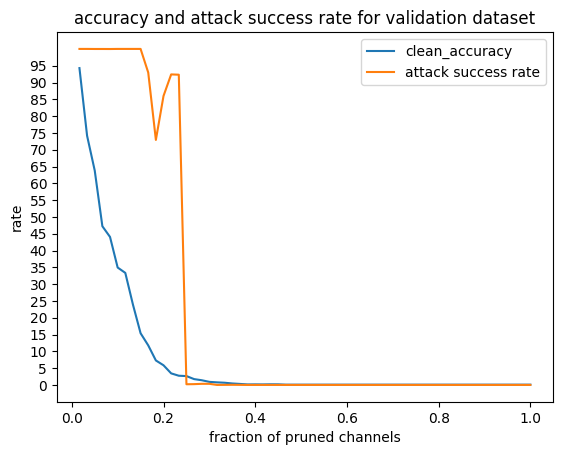

In [83]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis, clean_acc)
plt.plot(x_axis, asrate)
plt.yticks(np.arange(0, 100, step=5))
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

#Combining the models
Here we combine two models: original badnet model and the new pruned model

In [84]:
class G(keras.Model):
  def __init__(self, M, M_new):
      super(G, self).__init__()
      self.M = M
      self.M_new = M_new

  def predict(self, data):
      y = np.argmax(self.M(data), axis=1)
      y_new = np.argmax(self.M_new(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i] == y_new[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1284 # N + 1 when classification outputs differ
      return pred

In [85]:
# get test data
cl_test_data = 'cl/test.h5'
bd_test_data = 'bd/bd_test.h5'

In [86]:
# getting the stored models
test_model_X_2_filename = 'model_X=2.h5'
test_model_X_4_filename = 'model_X=4.h5'
test_model_X_10_filename = 'model_X=10.h5'
test_model_X_25_filename = 'model_X=25.h5'

test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)
test_model_X_25 = keras.models.load_model(test_model_X_25_filename)

In [87]:
x_test_cl, y_test_cl = data_loader(cl_test_data)
x_test_bd, y_test_bd = data_loader(bd_test_data)

In [88]:
print("x_test_data shape: ",x_test_cl.shape)
print("x_test_poisoned data shape: ",x_test_bd.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [89]:
G_model_X_2 = G(bd_model, test_model_X_2)
G_model_X_4 = G(bd_model, test_model_X_4)
G_model_X_10 = G(bd_model, test_model_X_10)
G_model_X_25 = G(bd_model, test_model_X_25)

#Evaluating on the test dataset

In [90]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_cl), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_cl))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_bd), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_bd))*100
print('2% drops model, Attack Success Rate:', asr_2)

401/401 [==============================] - 2s 6ms/step
2% drops model, the clean test data Classification accuracy: 94.13094310210445
401/401 [==============================] - 2s 6ms/step
2% drops model, Attack Success Rate: 100.0


In [91]:
cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_cl), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_cl))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_bd), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_bd))*100
print('4% drops model, Attack Success Rate:', asr_4)

401/401 [==============================] - 2s 6ms/step
4% drops model, the clean test data classification accuracy: 94.13094310210445
401/401 [==============================] - 2s 6ms/step
4% drops model, Attack Success Rate: 100.0


In [92]:
cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_cl), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_cl))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_bd), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_bd))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 3s 6ms/step
10% drops model, the clean test data classification accuracy: 74.24785658612628
401/401 [==============================] - 3s 8ms/step
10% drops model, Attack Success Rate: 100.0


In [93]:
cl_test_25_label_p = np.argmax(test_model_X_25.predict(x_test_cl), axis=1)
clean_test_25_accuracy = np.mean(np.equal(cl_test_25_label_p, y_test_cl))*100
print('25% drops model, the clean test data classification accuracy:', clean_test_25_accuracy)

bd_test_25_label_p = np.argmax(test_model_X_25.predict(x_test_bd), axis=1)
asr_25 = np.mean(np.equal(bd_test_25_label_p, y_test_bd))*100
print('25% drops model, Attack Success Rate:', asr_25)

401/401 [==============================] - 2s 6ms/step
25% drops model, the clean test data classification accuracy: 64.23226812159002
401/401 [==============================] - 3s 6ms/step
25% drops model, Attack Success Rate: 99.99220576773187


#Summarizing the fixed models

In [94]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy, clean_test_25_accuracy]
attack_rate = [asr_2, asr_4, asr_10, asr_25]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%", "repaired_25%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,94.130943,100.000000
repaired_4%,94.130943,100.000000
repaired_10%,74.247857,100.000000
repaired_25%,64.232268,99.992206


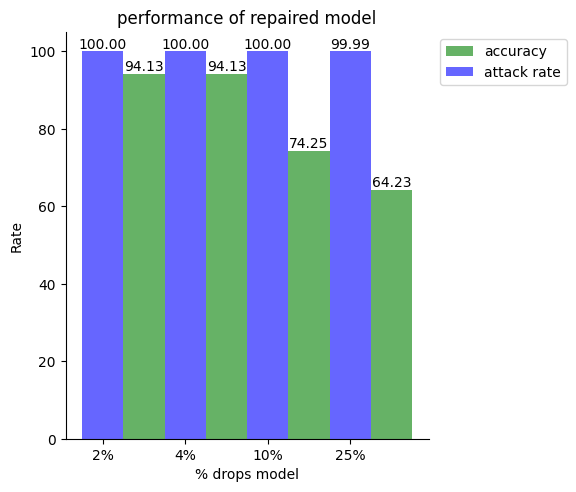

In [95]:
opacity = 0.6
bar_width = 0.5

bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='green', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='blue', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xlabel('% drops model')
plt.ylabel('Rate')
plt.xticks(range(len(test_acc)),('2%', '4%', '10%', '25%'))
plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

#Performace for combined models

In [96]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_cl)
G_clean_test_2_accuracy = np.mean(np.equal(G_cl_test_2_label_p, y_test_cl))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_bd)
G_asr_2 = np.mean(np.equal(G_bd_test_2_label_p, y_test_bd))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

Combined 2% drops model, the clean test data Classification accuracy: 93.95946999220577
Combined 2% drops model, Attack Success Rate: 100.0


In [97]:
G_cl_test_4_label_p = G_model_X_4.predict(x_test_cl)
G_clean_test_4_accuracy = np.mean(np.equal(G_cl_test_4_label_p, y_test_cl))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_bd)
G_asr_4 = np.mean(np.equal(G_bd_test_4_label_p, y_test_bd))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

Combined 4% drops model, the clean test data Classification accuracy: 93.95946999220577
Combined 4% drops model, Attack Success Rate: 100.0


In [98]:
G_cl_test_10_label_p = G_model_X_10.predict(x_test_cl)
G_clean_test_10_accuracy = np.mean(np.equal(G_cl_test_10_label_p, y_test_cl))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_bd)
G_asr_10 = np.mean(np.equal(G_bd_test_10_label_p, y_test_bd))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 10% drops model, the clean test data Classification accuracy: 74.09197194076384
Combined 10% drops model, Attack Success Rate: 100.0


In [99]:

G_cl_test_25_label_p = G_model_X_25.predict(x_test_cl)
G_clean_test_25_accuracy = np.mean(np.equal(G_cl_test_25_label_p, y_test_cl))*100
print('Combined 25% drops model, the clean test data Classification accuracy:', G_clean_test_25_accuracy)

G_bd_test_25_label_p = G_model_X_25.predict(x_test_bd)
G_asr_25 = np.mean(np.equal(G_bd_test_25_label_p, y_test_bd))*100
print('Combined 25% drops model, Attack Success Rate:', G_asr_25)

Combined 25% drops model, the clean test data Classification accuracy: 64.12314886983633
Combined 25% drops model, Attack Success Rate: 99.99220576773187


In [100]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy, G_clean_test_25_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10, G_asr_25]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%", "G_25%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')


,G_text_acc,G_attack_rate
G_model,,
G_2%,93.959470,100.000000
G_4%,93.959470,100.000000
G_10%,74.091972,100.000000
G_25%,64.123149,99.992206


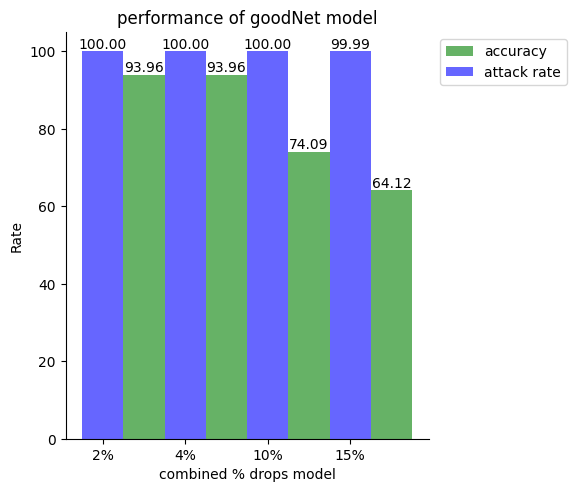

In [101]:
opacity = 0.6
bar_width = 0.5


bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='green', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='blue', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xlabel('combined % drops model')
plt.ylabel('Rate')
plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%', '15%'))
plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()